In [1]:
from utilities import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints, transforms
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')

## Time Series as a Regression Problem

In [2]:
co2_by_month = pd.read_csv(os.path.abspath('.') + '/data/monthly_mauna_loa_co2.csv')
co2_by_month["date_month"] = pd.to_datetime(co2_by_month["date_month"])
co2_by_month["CO2"] = co2_by_month["CO2"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]

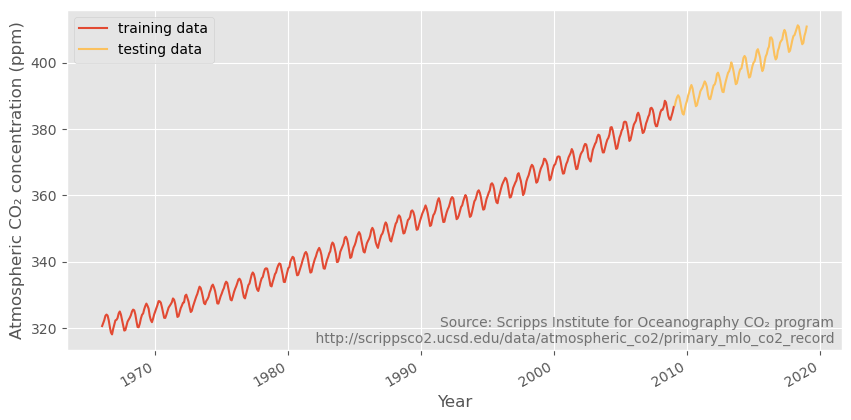

In [3]:
def plot_co2_data(fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(co2_by_month_training_data, label="training data")
    ax.plot(co2_by_month_testing_data, color="C4", label="testing data")
    ax.legend()
    ax.set(
        ylabel="Atmospheric CO₂ concentration (ppm)",
        xlabel="Year"
    )
    ax.text(0.99, .02,
            """Source: Scripps Institute for Oceanography CO₂ program
            http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record""",
            transform=ax.transAxes,
            horizontalalignment="right",
            alpha=0.5)
    fig.autofmt_xdate()
    return fig, ax


_ = plot_co2_data()

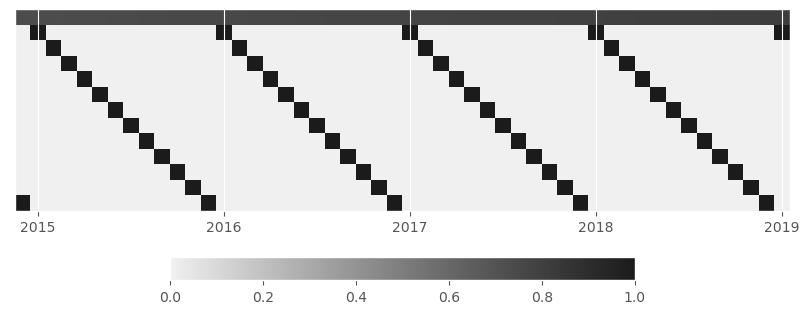

In [4]:
trend_all = np.linspace(0., 1., len(co2_by_month)).reshape(-1, 1)
trend_all = trend_all.astype(np.float32)
trend = trend_all[:-num_forecast_steps, :]

seasonality_all = pd.get_dummies(
    co2_by_month.index.month).values.astype(np.float32)
seasonality = seasonality_all[:-num_forecast_steps, :]

fig, ax = plt.subplots(figsize=(10, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
im = ax.imshow(X_subset.T, cmap='cet_gray_r')

label_loc = np.arange(1, 50, 12)
ax.set_xticks(label_loc)
ax.set_yticks([])
ax.set_xticklabels(co2_by_month.index.year[-50:][label_loc])
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=.6)

In [5]:
seasonality = torch.tensor(seasonality, dtype=torch.float64).float()
trend = torch.tensor(trend, dtype=torch.float64).float()
co2 = torch.tensor(co2_by_month_training_data.values.flatten(), dtype=torch.float64).float()

In [29]:
trend.T.shape

torch.Size([1, 517])

tensor([ 0.1471, -0.3695,  0.0098, -0.4926, -0.4392, -0.2308, -1.5289,  1.6313,
        -1.3531, -0.5863,  0.3869, -0.5353])

In [56]:
trend.shape[-1]

1

In [ ]:
coefs = dist.Normal(0., 1.).expand([trend.shape[-1]]).sample() 
print(coefs)

print(trend)


torch.matmul(coefs, trend.T)

In [60]:
def ts_regression_model(trend, seasonality, obs=None):

    intercept = pyro.sample('intercept', dist.Normal(0., 100.))
    trend_coef = pyro.sample('trend_coef', dist.Normal(0., 10.).expand([trend.shape[-1]]))
    noise = pyro.sample('noise', dist.HalfCauchy(0.1, 5.))
    
    with pyro.plate('seasonality', seasonality.shape[-1]):
        season_coef = pyro.sample('season_coef', dist.Normal(0., 1.))

    y_hat = intercept + torch.matmul(trend_coef, trend.T) + torch.matmul(season_coef, seasonality.T)
    
    with pyro.plate('co2', len(trend)):
        #y_hat = intercept + torch.mul(trend_coef, trend) + torch.matmul(season_coef, seasonality.T)
        observed = pyro.sample('observed', dist.Normal(y_hat, noise), obs=obs)

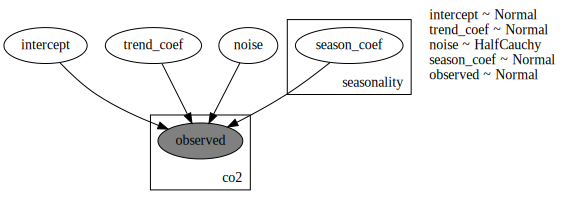

In [61]:
pyro.render_model(ts_regression_model, (trend, seasonality, co2), render_distributions=True)

In [62]:
kernel = NUTS(ts_regression_model)
mcmc_regression = MCMC(kernel, 500, 100)
mcmc_regression.run(trend, seasonality, co2)

Sample: 100%|██████████| 600/600 [06:54,  1.45it/s, step size=5.45e-04, acc. prob=0.950]


In [63]:
mcmc_regression.summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept    317.18      0.30    317.21    316.67    317.63      7.04      1.24
          noise      1.58      0.05      1.58      1.51      1.66    381.72      1.00
 season_coef[0]      0.35      0.33      0.33     -0.18      0.87     15.81      1.16
 season_coef[1]      0.91      0.32      0.89      0.37      1.40     12.34      1.10
 season_coef[2]      1.56      0.36      1.54      1.01      2.15     10.72      1.18
 season_coef[3]      2.67      0.36      2.65      2.12      3.26     14.02      1.14
 season_coef[4]      3.09      0.36      3.09      2.53      3.71     11.12      1.15
 season_coef[5]      2.45      0.35      2.44      1.92      3.03     12.01      1.13
 season_coef[6]      0.94      0.35      0.95      0.29      1.45      9.15      1.22
 season_coef[7]     -1.04      0.35     -1.03     -1.53     -0.44     11.93      1.14
 season_coef[8]     -2.80      0.35     -2.80     -3.

In [69]:
ts_samples = mcmc_regression.get_samples(1000)
post_samples = Predictive(ts_regression_model, ts_samples)(trend, seasonality, None)
az_ts_model = az.from_pyro(posterior=mcmc_regression, posterior_predictive=post_samples)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


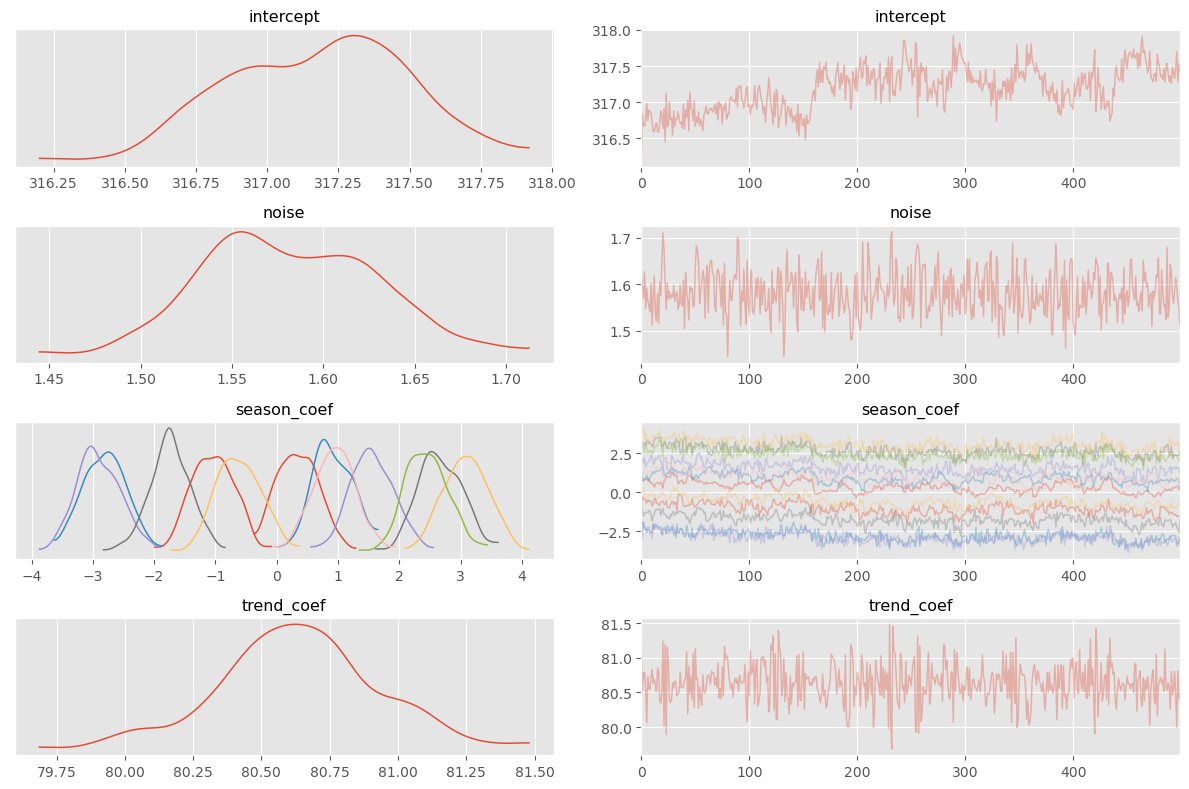

In [71]:
az.plot_trace(az_ts_model)
plt.tight_layout()

In [72]:
# prior samples
prior_samples = Predictive(ts_regression_model, {}, num_samples=100)(trend, seasonality)

In [74]:
prior_samples.keys()

dict_keys(['intercept', 'trend_coef', 'noise', 'season_coef', 'observed'])

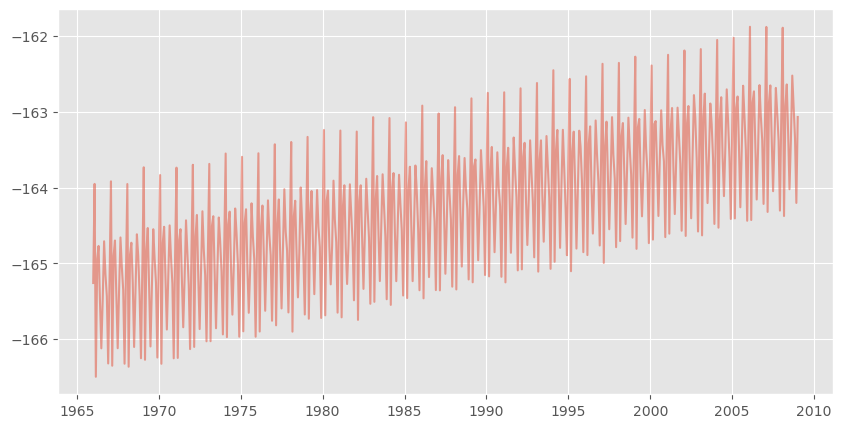

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    co2_by_month_training_data.index, prior_samples['observed'][0].T,
    alpha=0.5
    )
plt.show()

In [101]:
trend_posterior = ts_samples['intercept'] + torch.mul(ts_samples['trend_coef'].mean(), trend)
season_posterior = torch.matmul(ts_samples['season_coef'], seasonality.T)

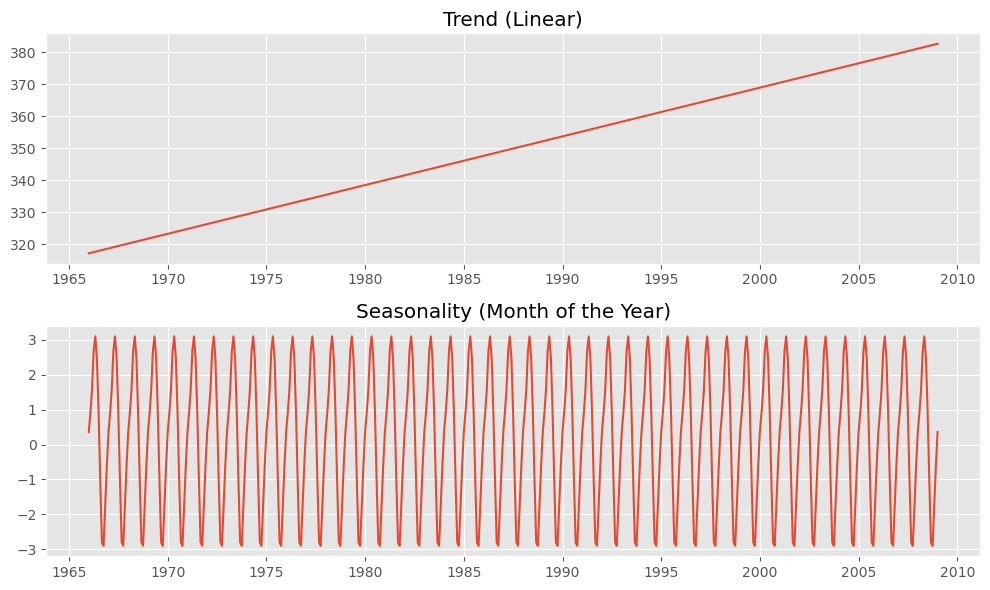

In [103]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(
    co2_by_month_training_data.index, 
    trend_posterior.mean(axis=1)
    )

ax[1].plot(
    co2_by_month_training_data.index,
    season_posterior.mean(axis=0)
)

ax[0].set_title('Trend (Linear)')
ax[1].set_title('Seasonality (Month of the Year)')
plt.tight_layout()
plt.show()

In [16]:
trend_all = torch.tensor(trend_all, dtype=torch.float64).float()
seasonality_all = torch.tensor(seasonality_all, dtype=torch.float64).float()

In [17]:
post_samples = Predictive(ts_regression_model, ts_samples)(trend_all, seasonality_all, None)

In [61]:
ts_samples.keys(), post_samples.keys()

(dict_keys(['intercept', 'noise', 'season_coef', 'trend_coef']),
 dict_keys(['observed']))

In [80]:
trend = ts_samples['intercept'] + torch.mul(trend, ts_samples['trend_coef'])
season = torch.matmul(ts_samples['season_coef'], seasonality.T).T
y_hat = trend + season

In [77]:
co2_by_month_training_data.index.shape

(517,)

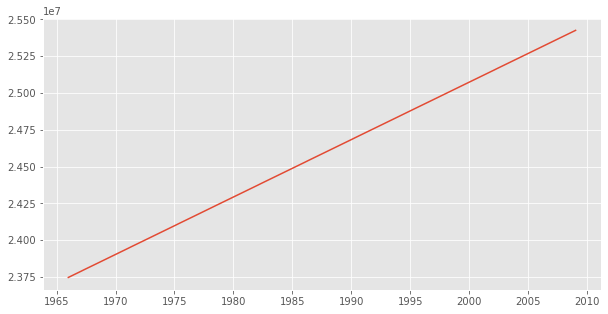

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(co2_by_month_training_data.index, y_hat.mean(axis=1))

In [37]:
sample_shape = torch.tensor(post_samples['observed'].size()[1:])


#torch.reshape(post_samples['observed'], )

In [39]:
[-1, torch.flatten(sample_shape)]

[-1, tensor([637, 637])]

In [38]:
sample_shape

tensor([637, 637])